In [1]:
import os
import numpy as np
import pandas as pd
import ndjson
import cv2
import matplotlib.pyplot as plt

# Define directories for input and output
raw_data_dir = r'D:\QuickDrawDataset(Apple&Banana)'  # Replace with the path to your NDJSON folder
output_dir = 'processed_data(Apple&Banana)'  # Output directory to save the processed data

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to convert strokes to image
def coordinates_to_image(coordinates, image_size=32):
    """
    Convert the list of coordinates into a grayscale image (32x32).
    Coordinates are expected as a list of (x, y) tuples.
    """
    image = np.ones((image_size, image_size), dtype=np.uint8) * 255  # White background
    
    # Loop through each stroke (a stroke is a list of (x, y) pairs)
    for stroke in coordinates:
        if len(stroke) > 1:
            for i in range(1, len(stroke)):
                try:
                    x1, y1 = stroke[i-1]  # Previous point
                    x2, y2 = stroke[i]    # Current point

                    # Ensure x1, y1, x2, y2 are integers
                    x1, y1 = int(x1), int(y1)
                    x2, y2 = int(x2), int(y2)

                    # Draw a line between consecutive coordinates
                    cv2.line(image, (x1, y1), (x2, y2), (0), 1)  # Black line
                except ValueError:
                    continue  # Skip invalid strokes

    # Resize image to ensure consistent dimensions (32x32)
    image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    
    return image

# Function to preprocess and save data
def preprocess_and_save_raw_data(input_file, label, image_size=32, batch_size=100):
    """Stream through the NDJSON file, convert data, and save images one by one"""
    with open(input_file, 'r') as file:
        reader = ndjson.reader(file)
        
        images = []
        labels = []
        batch_index = 1  # Start with batch 1

        # Iterate through the NDJSON file (drawing each item one by one)
        for i, entry in enumerate(reader):
            drawing = entry['drawing']
            
            # Skip empty or malformed data (e.g., empty drawings or invalid strokes)
            if not drawing or any(len(stroke) == 0 for stroke in drawing):
                continue  # Skip this entry if the drawing is empty or malformed
            
            # Convert strokes to an image
            image = coordinates_to_image(drawing, image_size)
            images.append(image)
            labels.append(label)  # Use the category name as the label
            
            # Save images and labels after processing every batch (e.g., every 100 entries)
            if (i + 1) % batch_size == 0:
                # Save images and labels into a numpy array and csv
                images_np = np.array(images)
                labels_df = pd.DataFrame(labels, columns=['label'])
                
                # Save images as .npy files in the output directory
                np.save(os.path.join(output_dir, f'{label}_images_{batch_index}.npy'), images_np)
                
                # Save labels as .csv files in the output directory
                labels_df.to_csv(os.path.join(output_dir, f'{label}_labels_{batch_index}.csv'), index=False)
                
                # Reset images and labels for the next batch
                images.clear()
                labels.clear()
                batch_index += 1  # Increment batch number

        # Save remaining images if they exist (in case the total number of items is not divisible by batch_size)
        if images:
            images_np = np.array(images)
            labels_df = pd.DataFrame(labels, columns=['label'])
            np.save(os.path.join(output_dir, f'{label}_images_{batch_index}.npy'), images_np)
            labels_df.to_csv(os.path.join(output_dir, f'{label}_labels_{batch_index}.csv'), index=False)

# Main function to process NDJSON files for apple and banana categories
def process_all_files():
    categories = ['apple', 'banana']
    
    for label in categories:
        input_file = os.path.join(raw_data_dir, f'full_raw_{label}.ndjson')  # Ensure your files are named like 'apple_raw.ndjson' or 'banana_raw.ndjson'
        print(f"Processing {label} data...")
        preprocess_and_save_raw_data(input_file, label)

# Call the function to process all files
process_all_files()


Processing apple data...
Processing banana data...


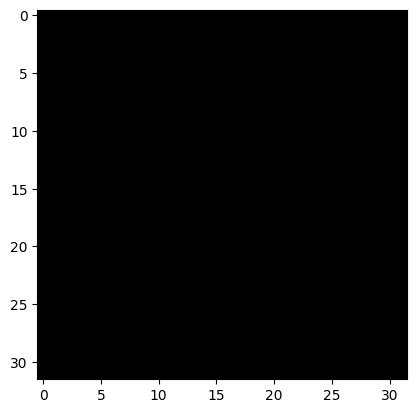

In [3]:
# Load the first image to visualize
apple_images = np.load('processed_data(Apple&Banana)/apple_images_1.npy')
plt.imshow(apple_images[0], cmap='gray')  # Display first image in grayscale
plt.show()